# Whiteboard Test

Trying to understand the difference between defining the system based on EKE and MKE

In [1]:
import xarray as xr
import numpy as np
import gsw
import matplotlib.pyplot as plt
from importlib import reload
from cmocean import cm as cmo
import xrft
import pandas as pd
import scipy.ndimage as filter


import density_funcs as df
import EV_funcs as ef
import filt_funcs as ff
import plot_funcs as pf

In [2]:
reload(df)
reload(ef)
reload(ff)
reload(pf);

In [3]:
float_z = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_z.nc')
float_r = xr.open_dataset('202206_floats/float_ID:(1901700)_ds_rho.nc')

In [4]:
l1 = 100
l2 = 200
l3 = 400
n = 100

MKE1 = ef.get_MV(float_z,l1,variable='SPICE')
MKE2 = ef.get_MV(float_z,l2,variable='SPICE')
MKE3 = ef.get_MV(float_z,l3,variable='SPICE')

EKE1 = ef.get_EV(float_z,l1,variable='SPICE')
EKE2 = ef.get_EV(float_z,l2,variable='SPICE')
EKE3 = ef.get_EV(float_z,l3,variable='SPICE')

In [5]:
MKE0_v = EKE1
MKE1_v = MKE1 - MKE2
MKE2_v = MKE2 - MKE3
MKE3_v = MKE3

EKE0_v = EKE1
EKE1_v = EKE2 - EKE1
EKE2_v = EKE3 - EKE2
EKE3_v = MKE3

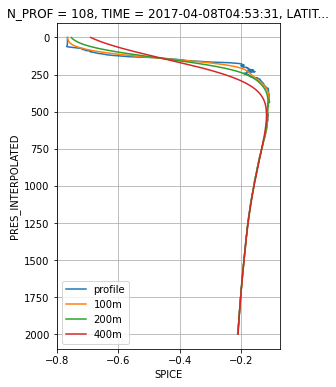

In [6]:
plt.figure(figsize=(4,6))

float_z.isel(N_PROF=n).SPICE.plot(y='PRES_INTERPOLATED',label='profile')
plt.plot(ff.get_filt_prof(float_z.isel(N_PROF=n).SPICE,l1),float_z.PRES_INTERPOLATED,label='{}m'.format(l1))
plt.plot(ff.get_filt_prof(float_z.isel(N_PROF=n).SPICE,l2),float_z.PRES_INTERPOLATED,label='{}m'.format(l2))
plt.plot(ff.get_filt_prof(float_z.isel(N_PROF=n).SPICE,l3),float_z.PRES_INTERPOLATED,label='{}m'.format(l3))

plt.gca().invert_yaxis()
plt.legend()
plt.grid()

plt.savefig('profiles')

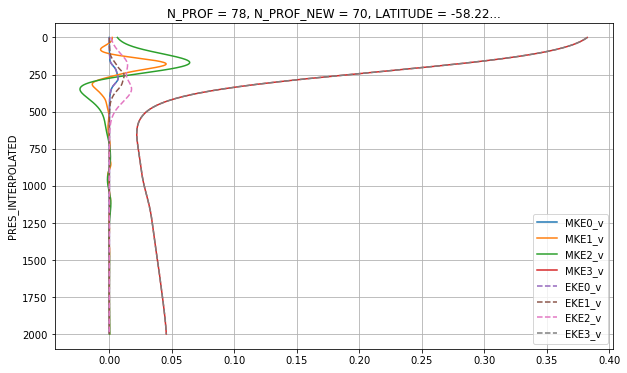

In [7]:
n = 70
plt.figure(figsize=(10,6))
MKE0_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='MKE0_v')
MKE1_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='MKE1_v')
MKE2_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='MKE2_v')
MKE3_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',label='MKE3_v')

EKE0_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE0_v')
EKE1_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE1_v')
EKE2_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE2_v')
EKE3_v.isel(N_PROF=n).plot(y='PRES_INTERPOLATED',linestyle='--',label='EKE3_v')

plt.gca().invert_yaxis()
plt.legend()
plt.grid()

plt.savefig('EKE,MKE')

This could be something that never came up in Stenberg because SSH is more constant, less sharp changes

## do cross terms cancel in EKE? I'd be forever grateful if they did :)

$MKE =         + <<u>>^2            + 2<<u>u'>          + <u'>^2$
$EKE = <<u>^2> - <<u>>^2 + <2<u>u'> - 2<<u>u'> + <u'^2> - <u'>^2$

$u = <u> + u'$

In [8]:
l1 = 2.
l2 = 3.

In [9]:
y = np.linspace(0,10*np.pi)
u = np.sin(y) + np.sin(y/3 + np.pi/9)

In [10]:
u_filt_l1 = filter.gaussian_filter1d(u, l1)
u_filt_l2 = filter.gaussian_filter1d(u, l2)

In [11]:
u_anom_l1 = u - u_filt_l1
u_anom_l2 = u - u_filt_l2

Text(0.5, 0, 'tracer values')

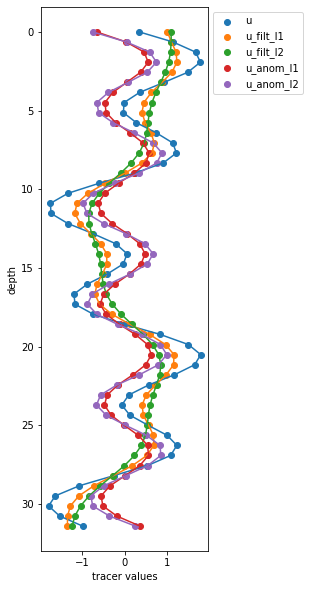

In [12]:
plt.figure(figsize=(3,10))
plt.scatter(u,y,label='u')
plt.scatter(u_filt_l1,y,label='u_filt_l1')
plt.scatter(u_filt_l2,y,label='u_filt_l2')
plt.scatter(u_anom_l1,y,label='u_anom_l1')
plt.scatter(u_anom_l2,y,label='u_anom_l2')
plt.plot(u,y)
plt.plot(u_filt_l1,y)
plt.plot(u_filt_l2,y)
plt.plot(u_anom_l1,y)
plt.plot(u_anom_l2,y)
plt.legend(bbox_to_anchor=(1,1))
plt.gca().invert_yaxis()
plt.ylabel('depth')
plt.xlabel('tracer values')

In [13]:
MKE_1 = filter.gaussian_filter1d(u, l1,  )**2
EKE_1 = filter.gaussian_filter1d(u**2, l1) - MKE_1

In [14]:
MKE_2 = filter.gaussian_filter1d((u_filt_l1 + u_anom_l1),   l1)**2
EKE_2 = filter.gaussian_filter1d((u_filt_l1 + u_anom_l1)**2,l1) - MKE_2

In [15]:
term_1 = filter.gaussian_filter1d(u_filt_l1**2,        l1)
term_2 = filter.gaussian_filter1d(u_filt_l1*u_anom_l1, l1)*2
term_3 = filter.gaussian_filter1d(u_anom_l1**2,        l1)
term_4 = filter.gaussian_filter1d(u_filt_l1,           l1)**2
term_5 = filter.gaussian_filter1d(u_filt_l1,           l1)*2*filter.gaussian_filter1d(u_anom_l1,l1)
term_6 = filter.gaussian_filter1d(u_anom_l1,           l1)**2

In [16]:
MKE_3 =                            term_4 + term_5 + term_6
EKE_3 = term_1 + term_2 + term_3 - term_4 - term_5 - term_6

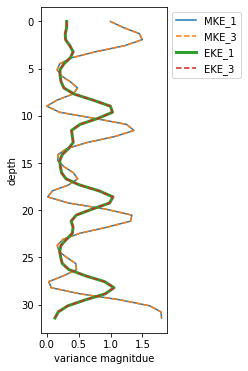

In [17]:
plt.figure(figsize=(6,6))

plt.subplot(1,2,1)
plt.plot(MKE_1,y,label='MKE_1')
plt.plot(MKE_3,y,label='MKE_3',linestyle='--')
plt.plot(EKE_1,y,label='EKE_1',linewidth='3')
plt.plot(EKE_3,y,label='EKE_3',linestyle='--')
#plt.plot(term_1,y,'--',label='1')
#plt.plot(term_2,y,'--',label='2')
#plt.plot(term_3,y,'--',label='3')
#plt.plot(term_4,y,'--',label='4')
#plt.plot(term_5,y,'--',label='5')
#plt.plot(term_6,y,'--',label='6')
plt.legend(bbox_to_anchor=(1,1))
plt.ylabel('depth')
plt.xlabel('variance magnitdue')
plt.gca().invert_yaxis()

plt.subplots_adjust(wspace=0.65)

In [ ]:
EKE0_1 = filter.gaussian_filter1d(u**2,l1) - filter.gaussian_filter1d(u,l1)**2
MKE1_1 = filter.gaussian_filter1d(u,l1)**2 - filter.gaussian_filter1d(u,l2)**2
EKE1_1 = filter.gaussian_filter1d(u**2,l2) - filter.gaussian_filter1d(u,l2)**2 - filter.gaussian_filter1d(u**2,l1) + filter.gaussian_filter1d(u,l1)**2
MKE2_1 = filter.gaussian_filter1d(u,l2)**2

In [25]:
term1  = filter.gaussian_filter1d(u_filt_l2**2,       l2)
term2  = filter.gaussian_filter1d(u_filt_l2*u_anom_l2,l2)*2
term3  = filter.gaussian_filter1d(u_anom_l2**2,       l2)
term4  = filter.gaussian_filter1d(u_filt_l2,          l2)**2
term5  = filter.gaussian_filter1d(u_filt_l2,          l2)*2*filter.gaussian_filter1d(u_anom_l2,l2)
term6  = filter.gaussian_filter1d(u_anom_l2,          l2)**2

term7  = filter.gaussian_filter1d(u_filt_l1**2,       l1)
term8  = filter.gaussian_filter1d(u_filt_l1*u_anom_l1,l1)*2
term9  = filter.gaussian_filter1d(u_anom_l1**2,       l1)
term10 = filter.gaussian_filter1d(u_filt_l1,          l1)**2
term11 = filter.gaussian_filter1d(u_filt_l1,          l1)*2*filter.gaussian_filter1d(u_anom_l1,l1)
term12 = filter.gaussian_filter1d(u_anom_l1,          l1)**2

In [26]:
EKE0_2 =                                                 term7 + term8 + term9 - term10 - term11 - term12
EKE1_2 = term1 + term2 + term3 - term4 - term5 - term6 - term7 - term8 - term9 + term10 + term11 + term12
MKE1_2 =                       - term4 - term5 - term6                         + term10 + term11 + term12
MKE2_2 =                         term4 + term5 + term6

Text(0.5, 1.0, 'MKE2')

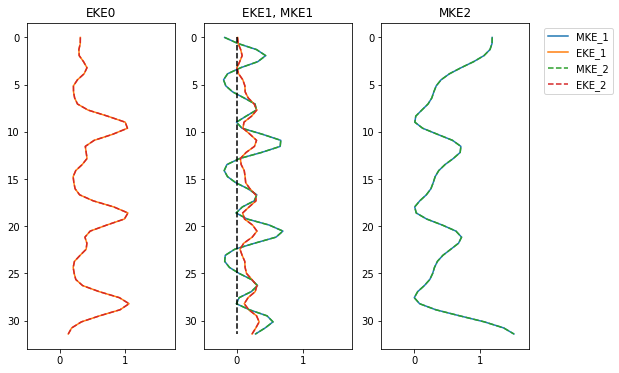

In [31]:
plt.figure(figsize=(9,6))

plt.subplot(1,3,1)
plt.plot(EKE0_1,y,color='tab:orange')
plt.plot(EKE0_2,y,'--',color='tab:red')
#plt.plot(term2,y,'--',label='term2',color='tab:orange')
#plt.plot(term4,y,'--',label='term4',color='tab:red')
#plt.plot(term6,y,'--',label='term6',color='tab:brown')
#plt.plot(term8,y,'--',label='term8',color='tab:gray')
#plt.plot(term10,y,'--',label='term10',color='tab:cyan')
#plt.plot(term12,y,linestyle='dashdot',label='term12',color='tab:orange')
plt.xlim(-0.5,1.75)
plt.gca().invert_yaxis()
plt.title('EKE0')

plt.subplot(1,3,2)
plt.plot(MKE1_1,y,label='MKE_1')
plt.plot(EKE1_1,y,label='EKE_1')
plt.plot(MKE1_2,y,'--',label='MKE_2')
plt.plot(EKE1_2,y,'--',label='EKE_2')
plt.vlines(0,0,10*np.pi,linestyle='--',color='k')
#plt.plot(term1,y,'--',label='term1',color='tab:blue')
#plt.plot(term2,y,'--',label='term2',color='tab:orange')
#plt.plot(term3,y,'--',label='term3',color='tab:green')
#plt.plot(term4,y,'--',label='term4',color='tab:red')
#plt.plot(term5,y,'--',label='term5',color='tab:purple')
#plt.plot(term6,y,'--',label='term6',color='tab:brown')
#plt.plot(term7,y,'--',label='term7',color='tab:pink')
#plt.plot(term8,y,'--',label='term8',color='tab:gray')
#plt.plot(term9,y,'--',label='term9',color='tab:olive')
#plt.plot(term10,y,'--',label='term10',color='tab:cyan')
#plt.plot(term11,y,linestyle='dashdot',label='term11',color='tab:blue')
#plt.plot(term12,y,linestyle='dashdot',label='term12',color='tab:orange')
plt.legend(bbox_to_anchor=(2.8,1))
plt.xlim(-0.5,1.75)
plt.gca().invert_yaxis()
plt.title('EKE1, MKE1')

plt.subplot(1,3,3)
plt.plot(MKE2_1,y,color='tab:blue')
plt.plot(MKE2_2,y,'--',color='tab:green')
#plt.plot(term3,y,'--',label='term3',color='tab:green')
#plt.plot(term7,y,'--',label='term7',color='tab:pink')
#plt.plot(term11,y,linestyle='dashdot',label='term11',color='tab:blue')
plt.xlim(-0.5,1.75)
plt.gca().invert_yaxis()
plt.title('MKE2')


## Rough Agenda

- Finish working in this notebook, and more specifically ensuring the two methods match in the plots above
- Go back to MLD notebook, what you want to do is have a MLD value for each profile, then pick different methods of chosing the boundaries. For example, chosing the deepest MLD for whatever bin you're working with, or the average MLD, or have a separate mask for each profile, then just average and let nans work out.
- Make a Steinberg Figure 3 type plot to prove to yourself you can do it. 
- Apply this MLD/masking approach to Steinberg Figure 5 to see if it makes much of a difference with noise. Also see, can you create these plots on density surfaces instead of depth? I wonder if they will look much difference.